<a href="https://colab.research.google.com/github/johanesPao/tensorflow_developer_certificate/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit 📰🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results is available here: https://arxiv.org/abs/1612.05251

📖 **Resource:** If you want to find the ground truth for this notebook (with lots of diagrams and text annotations) see the GitHub: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

## Confirm access to GPU

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-41141b95-16ec-d335-f008-c38fc462cafe)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sig
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best wats to become one with the data is to...

> Visualize, visualize, visualize

So with that in mind, let's write a function to read in all of the lines of a target text file

In [6]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt") # read the line with the training file
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number': 0,
  'target': 'BACKGROUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
  'total_lines': 11},
  ...]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [9]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, read it contents and sorts through each line,
  extracting things like the target label, the text of the sentence, 
  how many sentences are in the current abstract and what sentence 
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
      
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate line

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number # what number line does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfillled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 417 ms, sys: 72.9 ms, total: 490 ms
Wall time: 493 ms


In [11]:
# Check the first abstract of our training data
train_samples[:30]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

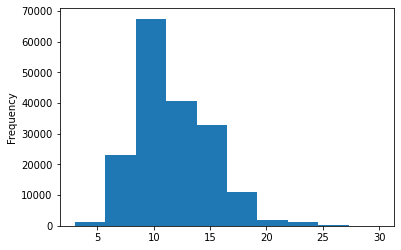

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [15]:
# Convert abstract text line into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [18]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as alwaysm we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

### Download helper function script

In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall and f1) and rather tahn rewriting it here, let's download it from our helper function script.

In [23]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-24 07:45:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-24 07:45:04 (76.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [24]:
from helper_functions import calculate_results

In [25]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [27]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

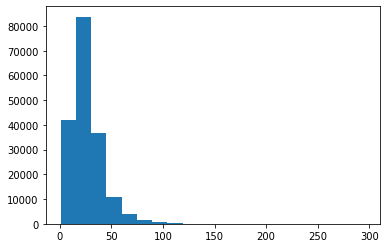

In [28]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [29]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [31]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f'Text:\n{target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text: {text_vectorizer([target_sentence])}')

Text:
nine children received insulin with dose escalations from @ to @ mg ( n = @ ) , @ to @ mg ( n = @ ) , or @ to @ mg ( n = @ ) after @ months ; @ children only received doses of @ mg ( n = @ ) or @ mg ( n = @ ) .

Length of text: 64

Vectorized text: [[ 1243   109    80   277     7   131 31428    27     6    68    40     6
     68    40    16     6    68    40    21    41   109   192    80   321
      4    68    40    16    68    40     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in vocab: {len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create custom text embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space)
                               name='token_embedding')

In [38]:
# Show example embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding):\n {vectorized_sentence}\n')
embedded_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedded_sentence}\n')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization:
 nine children received insulin with dose escalations from @ to @ mg ( n = @ ) , @ to @ mg ( n = @ ) , or @ to @ mg ( n = @ ) after @ months ; @ children only received doses of @ mg ( n = @ ) or @ mg ( n = @ ) .

Sentence after vectorization (before embedding):
 [[ 1243   109    80   277     7   131 31428    27     6    68    40     6
     68    40    16     6    68    40    21    41   109   192    80   321
      4    68    40    16    68    40     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.032879   -0.04565966  0.00629914 ... -0.04910284  0.01267684
    0.02295191]
  [ 0.03006339  0.00096543 -0.04286534 ... -0.00999236  0.04103154
    0.0130566 ]
  [ 0.04865359  0.02933398 -0.04072279 ... -0.0407679   0.01405135
    0.0184038 ]
  ...
  [ 0.03350702 -0.0316659   0.04583994 ... -0.0460932  -0.00241983
   -0.04809855

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [39]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [41]:
# Take the TensorSliceDataset's and turn them into prefetched dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [42]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [43]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 5)                 325   

In [44]:
# Prepare wandb for notebook in Google Colab
!pip install wandb
import wandb as wb
from wandb.keras import WandbCallback

# wb login
wb.login(key='924d78a46727fe1fb5374706bf1b8a158fe73971')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 145 kB 67.6 MB/s 
     |████████████████████████████████| 181 kB 68.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=6eb4aa2c4ad1b15741493b66183f751a253c75cf31641f16c51d7489b6ccb8d9
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [45]:
# wb model_1 init and config
wb.init(project='SkimLit',
        entity='jpao',
        name='model_1_conv1D',
        config={'n_layers': len(model_1.layers),
                'steps_multiplier': 0.1, 
                'epochs': 3})

wandb: Currently logged in as: jpao. Use `wandb login --relogin` to force relogin


In [46]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              epochs=wb.config.epochs,
                              steps_per_epoch=int(wb.config.steps_multiplier * len(train_dataset)), # only look at 10% of the batch to make it run faster initially
                              validation_data=valid_dataset,
                              validation_steps=int(wb.config.steps_multiplier * len(valid_dataset)), # only validate on 10% of batches
                              callbacks=[WandbCallback(save_model=False)])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/3
561/562 [============================>.] - ETA: 0s - loss: 0.9168 - accuracy: 0.6365

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /content/wandb/run-20220624_074544-2tmunbyg/files/model-best/assets


wandb: Adding directory to artifact (/content/wandb/run-20220624_074544-2tmunbyg/files/model-best)... Done. 1.1s


562/562 [==============================] - 27s 21ms/step - loss: 0.9159 - accuracy: 0.6368 - val_loss: 0.6895 - val_accuracy: 0.7384 - _timestamp: 1656056769.0000 - _runtime: 25.0000
Epoch 2/3
557/562 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.7536INFO:tensorflow:Assets written to: /content/wandb/run-20220624_074544-2tmunbyg/files/model-best/assets


wandb: Adding directory to artifact (/content/wandb/run-20220624_074544-2tmunbyg/files/model-best)... Done. 1.0s


562/562 [==============================] - 7s 13ms/step - loss: 0.6636 - accuracy: 0.7541 - val_loss: 0.6433 - val_accuracy: 0.7656 - _timestamp: 1656056778.0000 - _runtime: 34.0000
Epoch 3/3
562/562 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.7739INFO:tensorflow:Assets written to: /content/wandb/run-20220624_074544-2tmunbyg/files/model-best/assets


wandb: Adding directory to artifact (/content/wandb/run-20220624_074544-2tmunbyg/files/model-best)... Done. 1.1s


562/562 [==============================] - 7s 13ms/step - loss: 0.6207 - accuracy: 0.7739 - val_loss: 0.5986 - val_accuracy: 0.7829 - _timestamp: 1656056785.0000 - _runtime: 41.0000


In [47]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5992 - accuracy: 0.7857


[0.5991786122322083, 0.7857142686843872]

In [49]:
# Make predictions (our model predicts prediction probabilites for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.4580427e-01, 1.8622699e-01, 7.5766124e-02, 2.6306495e-01,
         2.9137695e-02],
        [3.4539390e-01, 3.7584358e-01, 1.1007058e-02, 2.5909472e-01,
         8.6607691e-03],
        [1.4114986e-01, 9.8665478e-03, 2.2415537e-03, 8.4670621e-01,
         3.5801022e-05],
        ...,
        [7.7656914e-06, 9.6533541e-04, 9.7898417e-04, 2.3550749e-06,
         9.9804556e-01],
        [5.9380710e-02, 5.0596946e-01, 6.8641983e-02, 6.7066506e-02,
         2.9894140e-01],
        [2.5203997e-01, 5.5408370e-01, 5.9421744e-02, 8.2252346e-02,
         5.2202240e-02]], dtype=float32), (30212, 5))

In [50]:
# Convert pred_probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [51]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.57142857142857,
 'f1': 0.7832649809420509,
 'precision': 0.7822961881558445,
 'recall': 0.7857142857142857}

In [52]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings grom TensorFlow Hub, more specifically the Universal Sentence Encoder (USE): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later create USE pretrained embeddings.

In [53]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        name='universal_sentence_encoder')

In [57]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f'Random sentence:\n {random_train_sentence}')
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n')
print(f'Length of sentence embedding: {len(use_embedded_sentence[0])}')

Random sentence:
 no difference in the varc combined @ day safety endpoint , all cause and cardiovascular mortality was observed .
Sentence after embedding:
[ 0.01732951 -0.05315121 -0.045616   -0.01016544  0.00439704 -0.0852512
  0.05155479  0.0450236   0.05737266  0.06371107  0.08995318  0.02351784
 -0.04181415  0.05138833  0.03167994 -0.06333555 -0.08533191 -0.00449362
  0.06015836  0.05502083 -0.01468055  0.01574104  0.00819961  0.05608274
  0.01213631  0.01061462  0.0396703   0.07114325 -0.07434957  0.02339842]

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [59]:
# Create Conv1D model with USE pretrained embedding layer
inputs = layers.Input(shape=[], dtype=tf.string, name='input_layer')
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation='softmax', name='output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_USE_feature_extractor')

In [60]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [61]:
# Compile the mode
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Setup wandb init and config
wb.init(project='SkimLit',
        entity='jpao',
        name='model_2_USE_feature_extractor',
        config={'n_layers': len(model_2.layers),
                'steps_multiplier': 0.1, 
                'epochs': 3})

accuracy,▁▇█
epoch,▁▅█
loss,█▂▁
val_accuracy,▁▅█
val_loss,█▄▁
accuracy,0.77385
best_epoch,2
best_val_loss,0.59857
epoch,2
loss,0.62069
val_accuracy,0.78291


In [62]:
# Fit the model
history_model_2 = model_2.fit(train_dataset,
                              epochs=wb.config.epochs,
                              steps_per_epoch=int(wb.config.steps_multiplier * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(wb.config.steps_multiplier * len(valid_dataset)),
                              callbacks=[WandbCallback(save_model=False)])

Epoch 1/3
562/562 [==============================] - 18s 25ms/step - loss: 0.9218 - accuracy: 0.6474 - val_loss: 0.7970 - val_accuracy: 0.6895 - _timestamp: 1656059518.0000 - _runtime: 32.0000
Epoch 2/3
562/562 [==============================] - 13s 24ms/step - loss: 0.7695 - accuracy: 0.7010 - val_loss: 0.7564 - val_accuracy: 0.7051 - _timestamp: 1656059531.0000 - _runtime: 45.0000
Epoch 3/3
562/562 [==============================] - 14s 24ms/step - loss: 0.7542 - accuracy: 0.7099 - val_loss: 0.7414 - val_accuracy: 0.7134 - _timestamp: 1656059545.0000 - _runtime: 59.0000


In [63]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.7436 - accuracy: 0.7127


[0.7436166405677795, 0.7126969695091248]

In [64]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.4800237e-01, 3.5538900e-01, 1.9920731e-03, 1.8666162e-01,
        7.9549365e-03],
       [3.3504656e-01, 5.3429210e-01, 3.3178115e-03, 1.2381963e-01,
        3.5239058e-03],
       [2.3358412e-01, 1.4101271e-01, 1.6885122e-02, 5.7252938e-01,
        3.5988715e-02],
       ...,
       [1.8773876e-03, 6.1976728e-03, 5.3735483e-02, 8.1008143e-04,
        9.3737936e-01],
       [4.6736086e-03, 5.2539714e-02, 2.1292587e-01, 1.4727368e-03,
        7.2838807e-01],
       [1.9505930e-01, 2.6256204e-01, 4.6257588e-01, 8.3068898e-03,
        7.1495883e-02]], dtype=float32)

In [66]:
# Convert the prediction probabilities found with feature extraction model to label
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [67]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.26969416126042,
 'f1': 0.7097518196401434,
 'precision': 0.7129184880203852,
 'recall': 0.7126969416126042}

In [68]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character embeddings.

Previously we've made token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [70]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [74]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'n o   d i f f e r e n c e   i n   t h e   v a r c   c o m b i n e d   @   d a y   s a f e t y   e n d p o i n t   ,   a l l   c a u s e   a n d   c a r d i o v a s c u l a r   m o r t a l i t y   w a s   o b s e r v e d   .'

In [76]:
# Split sequence-level data splits into characters-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [77]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_lens = np.mean(char_lens)
mean_char_lens

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <a list of 7 Patch objects>)

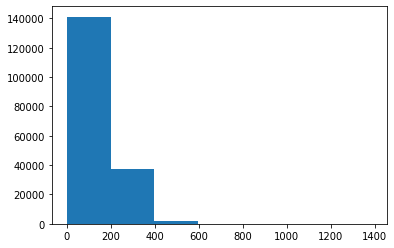

In [78]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [79]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [81]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [92]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization to "None" if you want leave punctuation in
                                    name='char_vectorizer')

In [93]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [94]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least common characters: {char_vocab[-5:]}')

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [97]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'\nLength of random_train_chars: {len(random_train_chars.split())}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'\nVectorized chars:\n {vectorized_chars}')
print(f'\nLength of vectorized chars: {len(vectorized_chars[0])}')

Charified text:
 t h e   p r i m a r y   e n d p o i n t   w a s   c o n t i n u o u s   @ - m o n t h   s m o k i n g   a b s t i n e n c e   ,   w h i c h   w a s   d e t e r m i n e d   b y   c a r b o n   m o n o x i d e   l e v e l s   .

Length of random_train_chars: 97

Vectorized chars:
 [[ 3 13  2 14  8  4 15  5  8 19  2  6 10 14  7  4  6  3 20  5  9 11  7  6
   3  4  6 16  7 16  9 15  7  6  3 13  9 15  7 23  4  6 18  5 22  9  3  4
   6  2  6 11  2 20 13  4 11 13 20  5  9 10  2  3  2  8 15  4  6  2 10 22
  19 11  5  8 22  7  6 15  7  6  7 24  4 10  2 12  2 21  2 12  9  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0

## Creating a character-level embedding

In [98]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name='char_embed')

In [102]:
# Test our character embedding layer
print(f'Charified text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (after vectorization and embedding):\n {char_embed_example}\n')
print(f'Character embedding shape: {char_embed_example.shape}')

Charified text:
 t h e   p r i m a r y   e n d p o i n t   w a s   c o n t i n u o u s   @ - m o n t h   s m o k i n g   a b s t i n e n c e   ,   w h i c h   w a s   d e t e r m i n e d   b y   c a r b o n   m o n o x i d e   l e v e l s   .

Embedded chars (after vectorization and embedding):
 [[[-0.00874367  0.01779372  0.02892205 ... -0.04720671  0.01317896
    0.02624431]
  [ 0.02027835 -0.01115841  0.03330094 ... -0.03566827 -0.01211015
    0.03543432]
  [ 0.0003444   0.01586628  0.01604709 ... -0.04517347 -0.02517875
   -0.01445   ]
  ...
  [-0.01998862  0.00342188 -0.01571394 ... -0.03455529 -0.01149378
    0.01265642]
  [-0.01998862  0.00342188 -0.01571394 ... -0.03455529 -0.01149378
    0.01265642]
  [-0.01998862  0.00342188 -0.01571394 ... -0.03455529 -0.01149378
    0.01265642]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [108]:
# Create a Conv1D with character-level embedded
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_3_conv1d_char_embeddings')

In [109]:
# Compile
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [110]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_2 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 

In [106]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [111]:
# Setup wandb init and config
wb.init(project='SkimLit',
        entity='jpao',
        name='model_3_conv1d_char_embeddings_max_pool',
        config={'n_layer': len(model_3.layers),
                'epochs': 3,
                'steps_multiplier': 0.1})

# Fit the model on chars only
history_model_3 = model_3.fit(train_char_dataset,
                              epochs=wb.config.epochs,
                              steps_per_epoch=int(wb.config.steps_multiplier * len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(wb.config.steps_multiplier * len(val_char_dataset)),
                              callbacks=[WandbCallback()])

accuracy,▁▆█
epoch,▁▅█
loss,█▃▁
val_accuracy,▁▇█
val_loss,█▃▁
accuracy,0.45168
best_epoch,2
best_val_loss,1.31276
epoch,2
loss,1.32519
val_accuracy,0.44448


Epoch 1/3
560/562 [============================>.] - ETA: 0s - loss: 1.2532 - accuracy: 0.4832

wandb: ERROR Can't save model in the h5py format. The model will be saved as W&B Artifacts in the SavedModel format.


INFO:tensorflow:Assets written to: /content/wandb/run-20220624_094749-2fmmxw22/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220624_094749-2fmmxw22/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220624_094749-2fmmxw22/files/model-best)... Done. 0.1s


562/562 [==============================] - 5s 8ms/step - loss: 1.2521 - accuracy: 0.4837 - val_loss: 1.1166 - val_accuracy: 0.5436 - _timestamp: 1656064079.0000 - _runtime: 6.0000
Epoch 2/3
552/562 [============================>.] - ETA: 0s - loss: 1.0844 - accuracy: 0.5577INFO:tensorflow:Assets written to: /content/wandb/run-20220624_094749-2fmmxw22/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220624_094749-2fmmxw22/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220624_094749-2fmmxw22/files/model-best)... Done. 0.1s


562/562 [==============================] - 4s 8ms/step - loss: 1.0832 - accuracy: 0.5580 - val_loss: 1.0131 - val_accuracy: 0.5911 - _timestamp: 1656064083.0000 - _runtime: 10.0000
Epoch 3/3
555/562 [============================>.] - ETA: 0s - loss: 0.9929 - accuracy: 0.6050INFO:tensorflow:Assets written to: /content/wandb/run-20220624_094749-2fmmxw22/files/model-best/assets


INFO:tensorflow:Assets written to: /content/wandb/run-20220624_094749-2fmmxw22/files/model-best/assets
wandb: Adding directory to artifact (/content/wandb/run-20220624_094749-2fmmxw22/files/model-best)... Done. 0.1s


562/562 [==============================] - 4s 8ms/step - loss: 0.9924 - accuracy: 0.6050 - val_loss: 0.9451 - val_accuracy: 0.6260 - _timestamp: 1656064088.0000 - _runtime: 15.0000


In [112]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.15396649, 0.27307358, 0.17687127, 0.33992502, 0.05616364],
       [0.16118072, 0.15424676, 0.0301521 , 0.6393572 , 0.01506324],
       [0.08916407, 0.11961822, 0.11596546, 0.6513708 , 0.02388148],
       ...,
       [0.01174894, 0.05019321, 0.12744747, 0.02803744, 0.7825729 ],
       [0.04798421, 0.11705382, 0.27269667, 0.07095789, 0.4913074 ],
       [0.430485  , 0.26271364, 0.14616957, 0.12674744, 0.03388435]],
      dtype=float32)

In [113]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 3, 3, ..., 4, 4, 0])>

In [114]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 62.20045015225738,
 'f1': 0.612037741868314,
 'precision': 0.631083046845633,
 'recall': 0.6220045015225738}

In [115]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}